# 🎯 Model Training Pipeline

This notebook implements a comprehensive model training process for fraud detection, incorporating various techniques to handle class imbalance and optimize model performance.

## 📋 Key Components

1. **Standard Training**
   - Baseline model without balancing or tuning
   - Helps establish performance baseline
   - Identifies potential overfitting issues

2. **Balanced Training**
   - Addresses class imbalance using undersampling
   - Improves model performance on minority class
   - Uses imbalanced-learn pipeline for proper validation

3. **Hyperparameter Optimization**
   - Grid search with cross-validation
   - Optimizes model parameters
   - Ensures robust performance across folds

## 📚 Import Libraries and Load Data

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import sys

# Add project root to Python path for importing custom modules
sys.path.append('../../')

In [11]:
data = pd.read_parquet( '../data/train_data.parquet')
metadata_columns = ['trans_date_trans_time', 'gender', 'street']
X = data.drop(columns=['is_fraud'] + metadata_columns)
y = data['is_fraud']

# Split for demonstration
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Data loaded and split.") 

Data loaded and split.


## 🎯 Standard Model Training - Overfitting (No Tuning)

Training a baseline LightGBM model without any balancing or hyperparameter tuning to establish a performance baseline.

### Key Points:
- Uses default parameters
- No class balancing
- Helps identify overfitting patterns
- Serves as reference for improvements

In [12]:
from lightgbm import LGBMClassifier


Training overfit model (no tuning)...
[LightGBM] [Info] Number of positive: 4889, number of negative: 844219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 849108, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005758 -> initscore=-5.151424
[LightGBM] [Info] Start training from score -5.151424
Overfit Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    211056
           1       0.58      0.65      0.61      1222

    accuracy                           1.00    212278
   macro avg       0.79      0.83      0.80    212278
weighted avg       1.00      1.00      1.00    212278



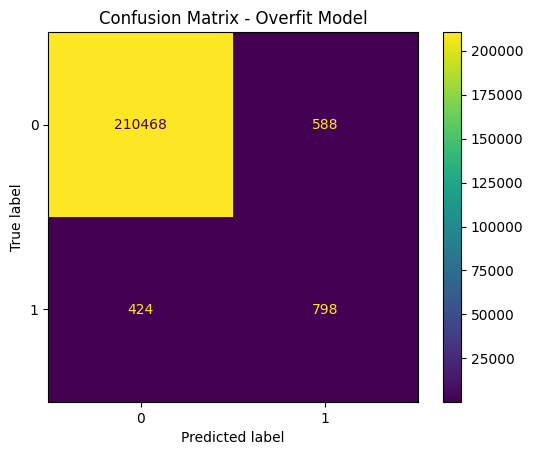

Overfit model training complete.


In [13]:
print("\nTraining overfit model (no tuning)...")
# Overfitting model (no tuning, high complexity)
overfit_model = LGBMClassifier(n_estimators=500, num_leaves=128, random_state=42, objective='binary')
overfit_model.fit(X_train, y_train)

y_pred_overfit = overfit_model.predict(X_test)
print('Overfit Model Classification Report:')
print(classification_report(y_test, y_pred_overfit))

cm_overfit = confusion_matrix(y_test, y_pred_overfit)
disp_overfit = ConfusionMatrixDisplay(cm_overfit)
disp_overfit.plot()
plt.title('Confusion Matrix - Overfit Model')
plt.show()
print("Overfit model training complete.")

## ⚖️ Balanced Model Training

Addressing class imbalance using RandomUnderSampler to improve model performance on the minority class.

### Implementation Notes:
- Uses imbalanced-learn pipeline
- Maintains proper validation process
- Prevents data leakage
- Sampling ratio: 20% (minority/majority)

In [14]:
from imblearn.under_sampling import RandomUnderSampler

In [15]:

print("\nTraining model on balanced data...")

# Define the undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Resample the training data
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)


Training model on balanced data...


In [16]:
print("Original training data class distribution:")
print(y_train.value_counts(normalize=True))
print("\nBalanced training data class distribution:")
print(y_train_balanced.value_counts(normalize=True))

# Train a simple model on the balanced data
balanced_model = LGBMClassifier(random_state=42)
balanced_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on the original, imbalanced test set
y_pred_balanced = balanced_model.predict(X_test)

Original training data class distribution:
is_fraud
0    0.994242
1    0.005758
Name: proportion, dtype: float64

Balanced training data class distribution:
is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64
[LightGBM] [Info] Number of positive: 4889, number of negative: 4889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 9778, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000



Balanced Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    211056
           1       0.16      0.98      0.28      1222

    accuracy                           0.97    212278
   macro avg       0.58      0.98      0.63    212278
weighted avg       1.00      0.97      0.98    212278



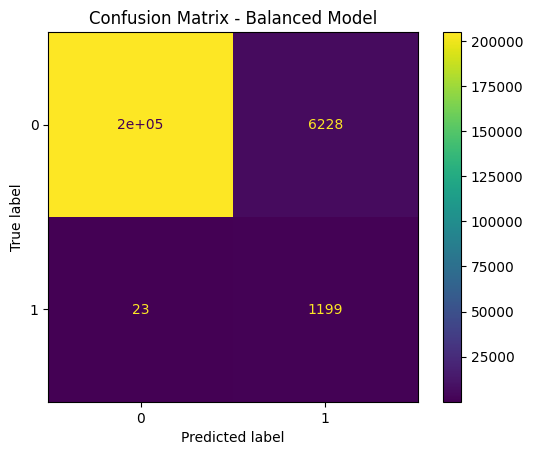

Balanced model training complete.


In [17]:
print('\nBalanced Model Classification Report:')
print(classification_report(y_test, y_pred_balanced))

cm_balanced = confusion_matrix(y_test, y_pred_balanced)
disp_balanced = ConfusionMatrixDisplay(cm_balanced)
disp_balanced.plot()
plt.title('Confusion Matrix - Balanced Model')
plt.show()
print("Balanced model training complete.") 

## 🔧 Hyperparameter Optimization

Implementing grid search with cross-validation to find optimal model parameters.

### Parameters to Optimize:
- Number of estimators: [20, 50, 200, 500]
- Number of leaves: [5, 10, 80, 100]
- Minimum data in leaf: [10, 50, 100, 200]
- Early stopping: 10 rounds

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
# Define hyperparameter grid for optimization
hyperparameters = {
    'class__n_estimators': [20, 50, 200, 500],
    "class__objective": ["binary"],
    "class__early_stopping_round": [10],
    "class__num_leaves": [5, 10, 80, 100],
    "class__min_data_in_leaf": [10, 50, 100, 200],
}

In [20]:
# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42, objective='binary'),
    param_grid=hyperparameters,
    cv=3,
    scoring='average_precision',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

print(f"Best parameters found via GridSearchCV: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Warning] Unknown parameter: class__n_estimators
[LightGBM] [Warning] Unknown parameter: class__num_leaves
[LightGBM] [Warning] Unknown parameter: class__objective
[LightGBM] [Warning] Unknown parameter: class__early_stopping_round
[LightGBM] [Warning] Unknown parameter: class__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: class__n_estimators
[LightGBM] [Warning] Unknown parameter: class__num_leaves
[LightGBM] [Warning] Unknown parameter: class__objective
[LightGBM] [Warning] Unknown parameter: class__early_stopping_round
[LightGBM] [Warning] Unknown parameter: class__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: class__n_estimators
[LightGBM] [Warning] Unknown parameter: class__num_leaves
[LightGBM] [Warning] Unknown parameter: class__objective
[LightGBM] [Warning] Unknown parameter: class__early_stopping_round
[LightGBM] [Warning] Unknown parameter: class__min_data_in_leaf
[LightGBM] [Warni


Training model with GridSearchCV best parameters...
[LightGBM] [Warning] Unknown parameter: class__n_estimators
[LightGBM] [Warning] Unknown parameter: class__num_leaves
[LightGBM] [Warning] Unknown parameter: class__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: class__objective
[LightGBM] [Warning] Unknown parameter: class__early_stopping_round
GridSearchCV Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    211056
           1       0.16      0.98      0.28      1222

    accuracy                           0.97    212278
   macro avg       0.58      0.98      0.63    212278
weighted avg       1.00      0.97      0.98    212278



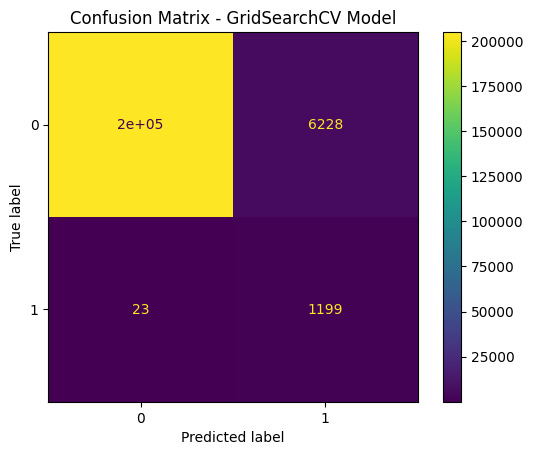

GridSearchCV model training complete.


In [21]:
print("\nTraining model with GridSearchCV best parameters...")
grid_model = grid_search.best_estimator_
y_pred_grid = grid_model.predict(X_test)

print('GridSearchCV Model Classification Report:')
print(classification_report(y_test, y_pred_grid))

cm_grid = confusion_matrix(y_test, y_pred_grid)
disp_grid = ConfusionMatrixDisplay(cm_grid)
disp_grid.plot()
plt.title('Confusion Matrix - GridSearchCV Model')
plt.show()
print("GridSearchCV model training complete.")

## ⚖️ Balanced Model Training - Good Fit (With Tuning via Optuna)

In [22]:
import optuna
from sklearn.model_selection import StratifiedKFold
from statistics import median

In [23]:
def objective(trial):
    params = {
        'objective': 'binary',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'num_leaves': trial.suggest_int('num_leaves', 8, 64),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(np.mean(preds == y_val))
    return median(scores)

[I 2025-06-23 14:59:50,836] A new study created in memory with name: no-name-ddef3aa5-4756-4ef0-9e78-9de1146f1ac1



Starting hyperparameter tuning with Optuna...


[I 2025-06-23 14:59:52,569] Trial 0 finished with value: 0.9965516754052488 and parameters: {'n_estimators': 70, 'num_leaves': 8, 'min_data_in_leaf': 100, 'learning_rate': 0.01579022283635514, 'reg_alpha': 0.5915656689507389}. Best is trial 0 with value: 0.9965516754052488.
[I 2025-06-23 14:59:57,281] Trial 1 finished with value: 0.9965976059582526 and parameters: {'n_estimators': 146, 'num_leaves': 34, 'min_data_in_leaf': 86, 'learning_rate': 0.13363313130746926, 'reg_alpha': 1.5960499102549848}. Best is trial 1 with value: 0.9965976059582526.
[I 2025-06-23 14:59:59,262] Trial 2 finished with value: 0.996654135869642 and parameters: {'n_estimators': 112, 'num_leaves': 8, 'min_data_in_leaf': 43, 'learning_rate': 0.17670392865533735, 'reg_alpha': 1.769146954363491}. Best is trial 2 with value: 0.996654135869642.
[I 2025-06-23 15:00:06,210] Trial 3 finished with value: 0.9961488997865996 and parameters: {'n_estimators': 279, 'num_leaves': 24, 'min_data_in_leaf': 65, 'learning_rate': 0.15

Best parameters found: {'n_estimators': 155, 'num_leaves': 63, 'min_data_in_leaf': 50, 'learning_rate': 0.0699448636839284, 'reg_alpha': 0.04950148876261751}

Training 'good fit' model with tuned parameters...
Good Fit Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    211056
           1       0.16      0.98      0.27      1222

    accuracy                           0.97    212278
   macro avg       0.58      0.97      0.63    212278
weighted avg       1.00      0.97      0.98    212278



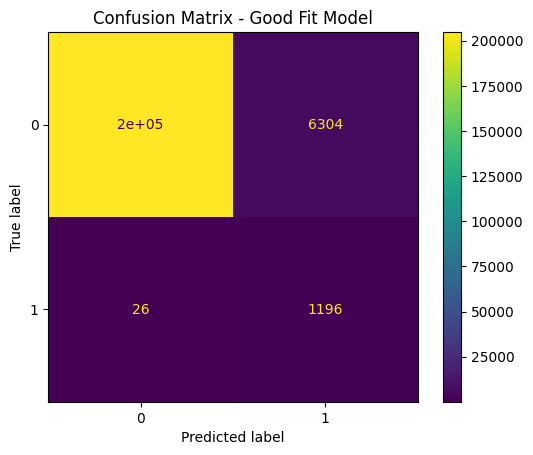

Tuned model training complete.


In [24]:
print("\nStarting hyperparameter tuning with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Best parameters found:', study.best_trial.params)

print("\nTraining 'good fit' model with tuned parameters...")
# Train final model with best params
goodfit_model = LGBMClassifier(**study.best_trial.params)
goodfit_model.fit(X_train_balanced, y_train_balanced)
y_pred_goodfit = goodfit_model.predict(X_test)
print('Good Fit Model Classification Report:')
print(classification_report(y_test, y_pred_goodfit))

cm_goodfit = confusion_matrix(y_test, y_pred_goodfit)
disp_goodfit = ConfusionMatrixDisplay(cm_goodfit)
disp_goodfit.plot()
plt.title('Confusion Matrix - Good Fit Model')
plt.show()
print("Tuned model training complete.") 


In [25]:
# save optuna model to models/optuna_model.pkl
import pickle
import sys

sys.path.append('../../')

# save model to models/optuna_model.pkl
pickle.dump(goodfit_model, open('../models/optuna_model.pkl', 'wb'))